# Projet 4 : Anticiper les besoins en consommation électrique de bâtiments
*Pierre-Eloi Ragetly*

Ce projet fait parti du parcours *DataScientist* d'OpenClassrooms.

L'objectif principal est de trouver un modèle permettant de prédire **les émissions de CO2 et la consommation totale d’énergie de bâtiments non destinés à l'habitation.**

Pour cela nous disposons des données de la ville de Seattle pour les années 2015 et 2016. Ces données sont à récupérer sur le site kaggle.

# Partie II : Feature Engineering

Ce notebook a pour but de présenter le travail effectué sur l'ingénierie de variables. C'est à dire toutes les transformations effectuées sur les variables afin d'améliorer les performances du modèle. Les données nettoyées (cf Partie I), seront utilisées.

De plus, Un premier tri parmi les variables sera effectué. Celles qui ne seront clairement pas pertinentes pour l'exercice de modélisation, par exemple l'adresse des bâtiments, seront écartées.

In [34]:
# Import des librairies usuelles
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
import seaborn as sns
import os

In [35]:
# Change some default parameters of matplotlib using seaborn
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'axes.titleweight': 'bold'})
sns.set(style='ticks')
current_palette = sns.color_palette('RdBu')
sns.set_palette(current_palette)

In [36]:
data_2015 = pd.read_csv('data/data_2015.csv')
data_2016 = pd.read_csv('data/data_2016.csv')

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Sélection-de-variables" data-toc-modified-id="Sélection-de-variables-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Sélection de variables</a></span></li><li><span><a href="#Analyse-des-variables-clés" data-toc-modified-id="Analyse-des-variables-clés-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Analyse des variables clés</a></span><ul class="toc-item"><li><span><a href="#Analyse-des-variables-à-prédire" data-toc-modified-id="Analyse-des-variables-à-prédire-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Analyse des variables à prédire</a></span></li><li><span><a href="#Analyse-de-l'ENERGY-STAR-Score" data-toc-modified-id="Analyse-de-l'ENERGY-STAR-Score-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Analyse de l'ENERGY STAR Score</a></span></li></ul></li><li><span><a href="#Traitement-des-variables-quantitatives" data-toc-modified-id="Traitement-des-variables-quantitatives-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Traitement des variables quantitatives</a></span><ul class="toc-item"><li><span><a href="#Traitement-des-variables-de-consommation" data-toc-modified-id="Traitement-des-variables-de-consommation-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Traitement des variables de consommation</a></span></li><li><span><a href="#Traitement-des-variables-de-superficie" data-toc-modified-id="Traitement-des-variables-de-superficie-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Traitement des variables de superficie</a></span></li><li><span><a href="#Traitement-des-variables-normalisées" data-toc-modified-id="Traitement-des-variables-normalisées-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Traitement des variables normalisées</a></span></li></ul></li><li><span><a href="#Traitement-des-variables-qualitatives" data-toc-modified-id="Traitement-des-variables-qualitatives-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Traitement des variables qualitatives</a></span><ul class="toc-item"><li><span><a href="#Traitement-des-variables-liées-au-type-d'utilisation-des-bâtiments" data-toc-modified-id="Traitement-des-variables-liées-au-type-d'utilisation-des-bâtiments-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Traitement des variables liées au type d'utilisation des bâtiments</a></span></li></ul></li></ul></div>

## Sélection de variables

Nombre de variables ne sont pas pertinentes pour modéliser la consommation en énergie ou l'émission de CO2. Elles viennent donc polluer le jeu de données et risque d'abaisser l'efficacité de notre modèle, il faut donc les écarter avant de procéder à l'entrainement des modèles.

Parmi elles nous allons trouver des variables renvoyant toutes la même donnée :
- DataYear
- ComplianceStatus
- City
- State

Nous avons aussi des variables qui pourraient s'apparenter à un identifiant. Ayant déja choisi comme identifiant *OSEBuildingID* (cf. Partie I), elles sont donc redondantes et peuvent être écartées sans risquer de perdre de l'information :
- PropertyName
- TaxParcelIdentificationNumber
- Address

D'autres n'auront clairement aucun lien avec les attributs que nous cherchons à modéliser :
- YearsENERGYSTARCertified
- DefaultData

Une variable contient très peu de valeurs renseignée, cinq en tout. De plus, il s'agit de texte, et est donc difficilement utilisable par les algorithmes d'apprentissage automatique classiques :
- Comments

Pour finir, certaines sont redondantes :
- BuildingType (redondante avec PrimaryPropertyType, cf. Partie I)
- CouncilDistrictCode (redondante avec Neighborhood)
- ZipCode (redondante avec Neighborhood)

In [37]:
cols_to_del = ['DataYear',
               'ComplianceStatus',
               'City',
               'State',
               'PropertyName',
               'TaxParcelIdentificationNumber',
               'Address',
               'YearsENERGYSTARCertified',
               'DefaultData',
               'Comments',
               'BuildingType',
               'CouncilDistrictCode',
               'ZipCode']

data_2015.set_index('OSEBuildingID', inplace=True)
data_2015.drop(columns=cols_to_del, inplace=True)

## Analyse des variables clés

### Analyse des variables à prédire

La première grandeur que nous cherchons à prédire est l'émission de CO2. Cette grandeur est renseignée dans nos jeux de données par la variable **TotalGHGEmissions**.

La deuxième est la consommation totale d'énergie, elle est renseignée par la variable **SiteEnergyUse(kBtu)**. Nous regarderons aussi sa version normalisée **SiteEnergyUse(kBtu)WN**. Ce WN veut dire *Weather Normalized*, il s'agit de données corrigées basées sur la différence entre la température de l'année en cours et la température moyenne de ces trente dernières années.

Commençons par voir la distribution de ces variables à l'aide d'un histogramme.

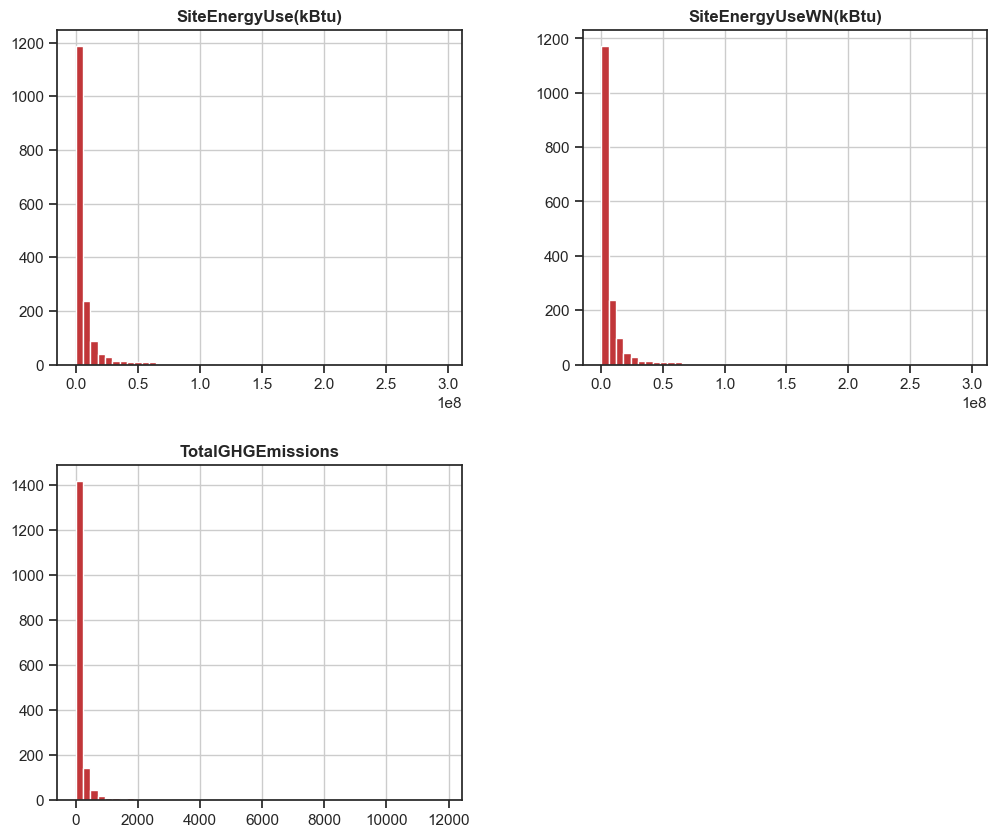

In [38]:
data_2015[['TotalGHGEmissions', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)']].hist(bins=50, figsize=(12, 10))
folder_path=os.path.join("charts")
if not os.path.isdir(folder_path):
    os.makedirs(folder_path)
plt.savefig("charts/targets_hist.png", bbox_inches = "tight")
plt.show()

Nous constatons que la distribution est fortement asymétrique pour les deux variables. La forme s'apparente plus à une distribution log normale que normale. Or, en général les algorithmes de Machine Learning (ML) sont plus performants quand les données suivent une distribution normale. Appliquons le log sur les deux variables, et regardons si on obtient une distribution un peu plus proche d'une cloche, forme typique de la distribution normale.

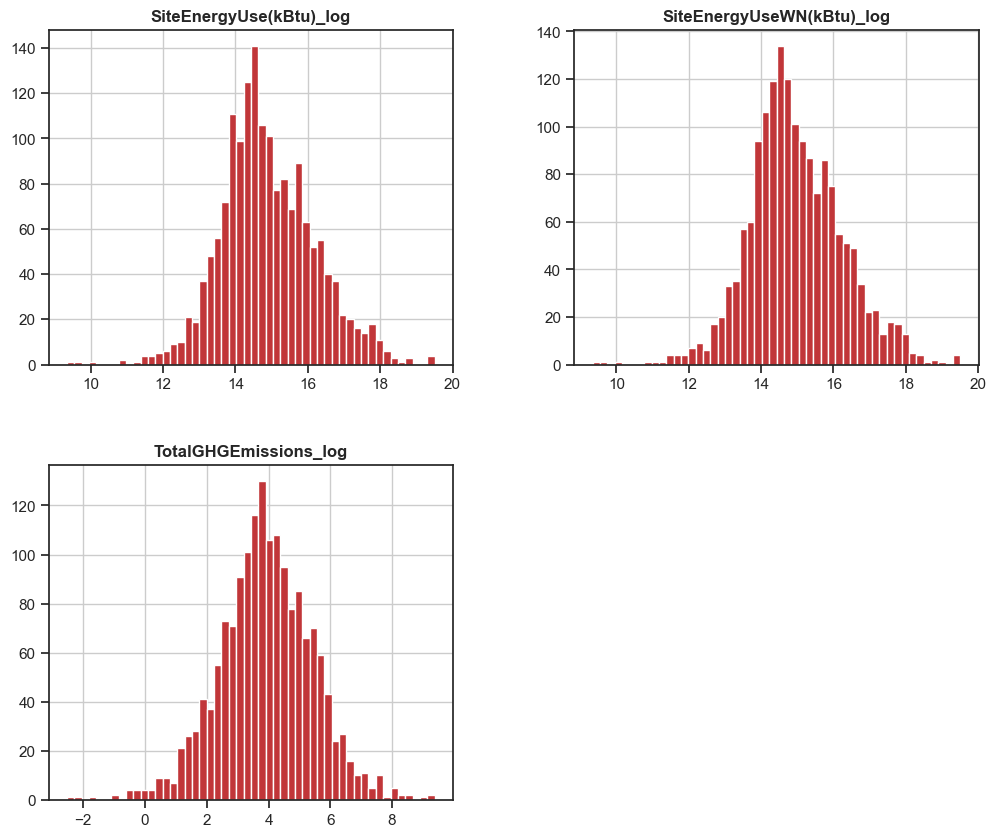

In [39]:
df = data_2015.copy()
df['SiteEnergyUse(kBtu)_log'] = np.log(df['SiteEnergyUse(kBtu)'])
df['SiteEnergyUseWN(kBtu)_log'] = np.log(df['SiteEnergyUseWN(kBtu)'])
df['TotalGHGEmissions_log'] = np.log(df['TotalGHGEmissions'])
df[['TotalGHGEmissions_log', 'SiteEnergyUseWN(kBtu)_log', 'SiteEnergyUse(kBtu)_log']].hist(bins=50, figsize=(12, 10))
plt.savefig("charts/targets_log_hist.png", bbox_inches = "tight")
plt.show()

C'est nettement mieux. **Nous entrainerons donc nos modèles sur le logarithme de ces variables. Puis nous appliquerons l'exponentielle sur les prédictions pour obtenir les bonnes valeurs.**

In [40]:
data_2015['SiteEnergyUse(kBtu)_log'] = np.log(data_2015['SiteEnergyUse(kBtu)'])
data_2015['SiteEnergyUseWN(kBtu)_log'] = np.log(data_2015['SiteEnergyUseWN(kBtu)'])
data_2015['TotalGHGEmissions_log'] = np.log(data_2015['TotalGHGEmissions'])

### Analyse de l'ENERGY STAR Score

Comme nous cherchons aussi à évaluer l'intérêt de l'**ENERGY STAR Score**, il serait pertinent de regarder cette dernière plus en détail avant de nous occuper des autres variables.

Dans notre jeu de donnée, ce score est renseigné par la variable *ENERGYSTARScore*.

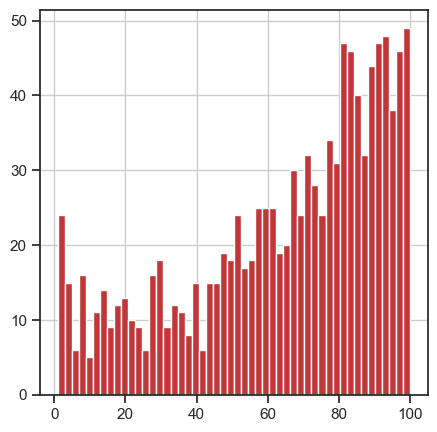

In [41]:
data_2015['ENERGYSTARScore'].hist(bins=50, figsize=(5, 5))
plt.savefig("charts/energystar_hist.png", bbox_inches = "tight")
plt.show()

Nous observons une distribution asymétrique, presque triangulaire. La distribution semble fortement éloignée de celles des variables cibles. Ceci peut être dû au fait que l'Énergie Star Score mesure l'efficacité énergétique. Or, pour mesurer cette dernière il nécessaire de prendre en compte la surface des bâtiments. il serait donc plus pertinent de comparer l'Énergie Star non pas directement à la consommation (ou émission) mais à l'intensité de consommation (ou d'émission), ie. aux variables :
- SiteEUI(kBtu/sf)
- GHGEmissionsIntensity

Un moyen rapide et visuel de comparer ces trois variables est d'utiliser un pair plot, pour cela nous utiliserons la méthode `scatter_matrix()` du module pandas.plotting.

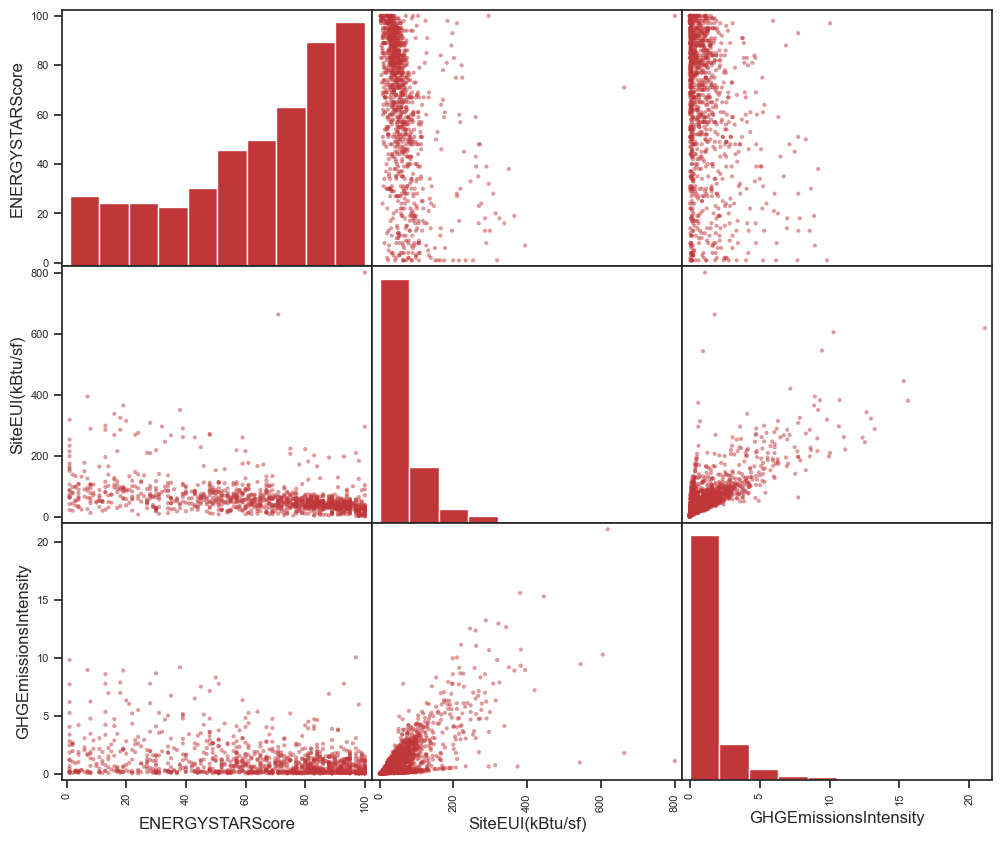

In [42]:
from pandas.plotting import scatter_matrix

features = ['ENERGYSTARScore','SiteEUI(kBtu/sf)', 'GHGEmissionsIntensity']
scatter_matrix(data_2015[features], figsize=(12, 10))
plt.savefig("charts/energystar_pairplot.png", bbox_inches = "tight")
plt.show()

De nouveau nous obtenons des distributions très éloignées. Il serait donc assez surprenant que la variable ENERGY STAR soit clé pour prédire la consommation totale d'énergie ou bien encore l'émission de CO2. 

## Traitement des variables quantitatives

Nous commencerons pas analyser les variables quantitatives, ie. les variables les plus simples à traiter. 

### Traitement des variables de consommation

L'objectif final étant de nous passer des relevés de consommation annuels, nous allons devoir transformer un peu les variables liées à la consommation.

Par exemple au lieu de garder la consommation de chaque type d'énergie nous pourrions calculer la proportion que représente ces énergie dans la consommation totale. Nous pourrions aussi calculer le pourcentage de sources énergétiques primaires (fuel, gaz naturel) et secondaires (vapeur, électricité).

Dans la partie I, nous avions retiré la variable *OtherFuel(kBtu)* car :
1. Elle n'était pas présente dans les données de 2016
2. Elle était systématiquement supérieure aux valeurs obtenues en retranchant la somme des autres sources énergétiques à la consommation totale.

Nous allons commençons par recréer cette variable, en imposant que cette variable soit égale à 0 si la la somme des autres sources énergétiques est supérieure à la consommation totale. Comme on travaillera ensuite avec des ratio, ces cas ne seront pas problématique. Pour l'instant on veut juste éviter d'avoir une consommation négative.

In [21]:
att_conso = ['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)']

data_2015['OtherFuel(kBtu)'] = data_2015['SiteEnergyUse(kBtu)'] - data_2015[att_conso].sum(axis=1)
# equalize all negative values to 0
cond = data_2015['OtherFuel(kBtu)'] >= 0
data_2015['OtherFuel(kBtu)'].where(cond, 0, inplace=True)

Nous pouvons maintenant caculer les ratio pour chaque énergie.

In [22]:
att_conso += ['OtherFuel(kBtu)']
for c in att_conso:
    name = c.replace("(kBtu)", "") + "_ratio"
    data_2015[name] = data_2015[c] / data_2015[att_conso].sum(axis=1)

Puis les ratio pour les énergie primaires et secondaires.

In [23]:
data_2015['Primary_ratio'] = data_2015['NaturalGas_ratio'] + data_2015['OtherFuel_ratio']
data_2015['Secondary_ratio'] = data_2015['SteamUse_ratio'] + data_2015['Electricity_ratio']

### Traitement des variables de superficie

Dans nos jeux de données la superficie est désignée par GFA pour Gross Floor Area. Nous avons la superficie totale, ainsi que la superficie dédiée aux bâtiments et celle dédiée aux parkings. Pour les deux dernières, il serait plus pertinent d'avoir les ratio que les superficies absolues.

In [24]:
att_gfa = ['PropertyGFAParking', 'PropertyGFABuilding(s)']
for c in att_gfa:
    name = c + "_ratio"
    data_2015[name] = data_2015[c] / data_2015[att_gfa].sum(axis=1)

## Traitement des variables qualitatives

### Traitement des variables liées au type d'utilisation des bâtiments

Les deux principales variables qui renseignent sur le type d'utilisation des bâtiments sont :
- PrimaryPropertyType
- ListOfAllPropertyUseTypes

Regardons si ces deux variables possèdent les mêmes modalités.

In [26]:
data_2015['PrimaryPropertyType'].value_counts()

Other                          208
Small- and Mid-Sized Office    165
Non-Refrigerated Warehouse     128
K-12 School                    119
Large Office                    99
Mixed Use Property              97
Retail Store                    75
Hotel                           69
Worship Facility                62
Distribution Center\n           42
Senior Care Community           40
Supermarket/Grocery Store       34
Medical Office                  31
College/University              21
Self-Storage Facility\n         19
Residence Hall/Dormitory        11
Hospital                         9
Restaurant\n                     9
Refrigerated Warehouse           6
SPS-District K-12                4
Distribution Center              1
Laboratory                       1
Self-Storage Facility            1
Restaurant                       1
Name: PrimaryPropertyType, dtype: int64

In [50]:
# Retreive all Property use types
list_of_lists = data_2015['ListOfAllPropertyUseTypes'].dropna().str.split(', ')
values = [item for sublist in list_of_lists for item in sublist]
# Keep only unique items
X = np.array(values)
list_of_use_types = np.unique(X)
print(len(list_of_use_types))
list_of_use_types

68


array(['Adult Education', 'Automobile Dealership', 'Bank Branch',
       'Bar/Nightclub', 'College/University',
       'Convenience Store without Gas Station', 'Convention Center',
       'Courthouse', 'Data Center', 'Distribution Center', 'Dry Cleaning',
       'Enclosed Mall', 'Fast Food Restaurant', 'Financial Office',
       'Fire Station', 'Fitness Center/Health Club/Gym', 'Food Sales',
       'Food Service', 'Hospital (General Medical & Surgical)', 'Hotel',
       'K-12 School', 'Laboratory', 'Library', 'Lifestyle Center',
       'Locksmith', 'Manufacturing/Industrial Plant', 'Medical Office',
       'Movie Theater', 'Multifamily Housing', 'Museum',
       'Non-Refrigerated Warehouse', 'Office', 'Other',
       'Other - Education', 'Other - Entertainment/Public Assembly',
       'Other - Lodging/Residential', 'Other - Mall',
       'Other - Public Services', 'Other - Recreation',
       'Other - Restaurant/Bar', 'Other - Services',
       'Other - Technology/Science', 'Other - Ut

Nous pouvons remarquer que les types d'utilisation des deux variables ne sont pas les mêmes. Nous allons créer une table d'association qui permettra de passer d'une variable à l'autre.

Pour cela nous allons créer un nouveau *DataFrame* à partir des deux variables *LargestPropertyUseType* et *PrimaryPropertyType*. Puis nous supprimerons les doublons à l'aide de la méthode `drop_duplicates()` de pandas.

In [58]:
associative_df = data_2015[['LargestPropertyUseType', 'PrimaryPropertyType']].dropna()
associative_df.drop_duplicates(inplace=True)
associative_df.reset_index(drop=True, inplace=True)
associative_df.head()

,LargestPropertyUseType,PrimaryPropertyType
0,Hotel,Hotel
1,Police Station,Other
2,Other - Entertainment/Public Assembly,Other
3,Library,Other
4,Fitness Center/Health Club/Gym,Other


Vérifions que chaque entrée de *LargestPropertyUseType* ne possède qu'une valeur pour *PrimaryPropertyType*.

In [62]:
n = associative_df[associative_df['LargestPropertyUseType'].duplicated(keep=False)].shape[0]
print(n)

39


Nous constatons que 39 valeurs de *LargestPropertyUseType* peuvent être associées à plusieurs valeurs pour *PrimaryPropertyType*. Comme c'est un nombre assez limité nous pouvons regarder ces individus plus en détail et ensuite choisir quelle valeur pour PrimaryPropertyType nous voulons garder.

In [65]:
idx = associative_df[associative_df['LargestPropertyUseType'].duplicated(keep=False)].index
associative_df.loc[idx].sort_values('LargestPropertyUseType')

,LargestPropertyUseType,PrimaryPropertyType
26,Distribution Center,Distribution Center\n
53,Distribution Center,Mixed Use Property
4,Fitness Center/Health Club/Gym,Other
63,Fitness Center/Health Club/Gym,Mixed Use Property
0,Hotel,Hotel
57,Hotel,Mixed Use Property
36,Laboratory,Other
30,Laboratory,Mixed Use Property
14,Medical Office,Medical Office
15,Medical Office,Mixed Use Property


In [25]:
data_2015.columns

Index(['PrimaryPropertyType', 'Neighborhood', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)',
       'NaturalGas(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity',
       'Latitude', 'Longitude', 'SiteEnergyUse(kBtu)_log',
       'TotalGHGEmissions_log', 'OtherFuel(kBtu)', 'SteamUse_ratio',
       'Electricity_ratio', 'NaturalGas_ratio', 'OtherFuel_ratio',
       'Primary_ratio', 'Secondary_ratio', 'PropertyGFAParking_ratio',
       'PropertyGFABuilding(s